# Preparing the Data

In [15]:
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print(f"n_letters:{n_letters}")
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn' and c in all_letters )

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(f"n_categories:{n_categories}")
print(f"len of category_lines:{len(category_lines)}")
print(f"len of all_categories:{len(all_categories)}")
print(category_lines['Italian'][:5])

n_letters:57
n_categories:18
len of category_lines:18
len of all_categories:18
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


# Turning Names into Tensors

In [11]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor("J"))
print(lineToTensor("Jones").size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


D:\anaconda\envs\torch-1.13.1-py-3.8\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Creating the Network

In [22]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

# Training

In [36]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [25]:
import random
def randomChoice(l):
    return l[random.randint(0, len(l)-1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    catgory, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Vietnamese / line = Sai
category = Vietnamese / line = Casales
category = Vietnamese / line = Thian
category = Vietnamese / line = Antar
category = Vietnamese / line = Tsalko
category = Vietnamese / line = Neville
category = Vietnamese / line = Travers
category = Vietnamese / line = Patrick
category = Vietnamese / line = Falkenrath
category = Vietnamese / line = Lemieux


# Plotting the Results

In [32]:
print(f"category_tensor:{category_tensor}")
print(f"line_tensor:{line_tensor}")

category_tensor:tensor([5])
line_tensor:tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [34]:
criterion = nn.NLLLoss()
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    return output, loss.item()

In [38]:
import time
import math
n_iters = 100000
print_every = 5000
plot_every = 1000
current_loss = 0
all_losses = []
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

D:\anaconda\envs\torch-1.13.1-py-3.8\Lib\site-packages\torch\nn\functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


5000 5% (0m 6s) 0.7947 Pantelakos / Greek ✓
10000 10% (0m 14s) 1.0525 Ha / Vietnamese ✓
15000 15% (0m 20s) 0.5072 Takeda / Japanese ✓
20000 20% (0m 27s) 0.7478 Chong / Korean ✓
25000 25% (0m 34s) 1.4559 Wateridge / English ✓
30000 30% (0m 41s) 0.4477 Trieu / Vietnamese ✓
35000 35% (0m 48s) 0.0964 Neroni / Italian ✓
40000 40% (0m 55s) 3.5686 Dzhavahishvili / Italian ✗ (Russian)
45000 45% (1m 2s) 1.7801 Ochoa / Arabic ✗ (Spanish)
50000 50% (1m 9s) 0.3604 Yandulsky / Russian ✓
55000 55% (1m 16s) 1.4300 Nader / Arabic ✓
60000 60% (1m 23s) 1.0184 Daviau / French ✓
65000 65% (1m 30s) 0.2470 Yoo / Korean ✓
70000 70% (1m 37s) 2.3705 Bach / Vietnamese ✗ (German)
75000 75% (1m 44s) 0.8491 Grabski / Russian ✗ (Czech)
80000 80% (1m 51s) 0.0147 Gudimov / Russian ✓
85000 85% (1m 58s) 1.8790 Palomo / Italian ✗ (Spanish)
90000 90% (2m 5s) 0.0389 Son / Korean ✓
95000 95% (2m 12s) 0.0515 Usami / Japanese ✓
100000 100% (2m 19s) 1.2384 Reyes / Dutch ✗ (Spanish)


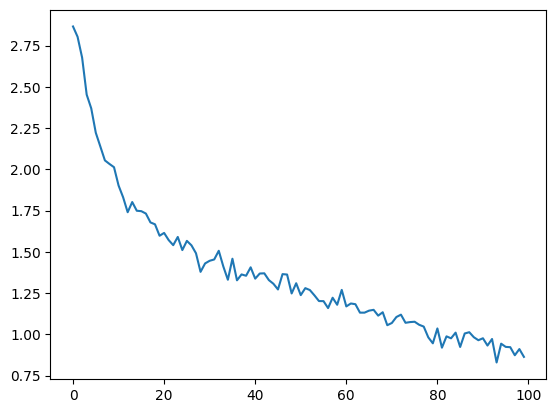

In [40]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

# Evaluating the Results

In [44]:
from tqdm import tqdm

n_confusion = 10000
count = 0

def evaluate(line_tensor):
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output

for i in tqdm(range(n_confusion)):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    if category == guess:
        count += 1
print(count/n_confusion)

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]D:\anaconda\envs\torch-1.13.1-py-3.8\Lib\site-packages\torch\nn\functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1536.03it/s]

0.7122


# Running on User Input

In [55]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        topv, topi = output.topk(n_predictions, 1, True)
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))

predict('Dovesky')
predict('Jackson')
predict('Jiang')
predict('Chang')


> Dovesky
(-0.34) Czech
(-1.81) Russian
(-2.30) English

> Jackson
(-0.14) Scottish
(-2.29) English
(-4.57) French

> Jiang
(-0.37) Chinese
(-1.74) Korean
(-3.16) Vietnamese

> Chang
(-0.04) Korean
(-3.38) Chinese
(-5.42) Vietnamese
